# K-means

In the unsupervised setting, one of the most straightforward tasks we can perform is to find groups of data instances which are similar between each other. We call such groups of data points clusters.

We position ourselves in the setting where we have access to a dataset $D$ that consists of instances $x \in \mathbb{R}^n$. For example, if our instances have two features $x_1$ and $x_2$ we are in the $\mathbb{R}^2$ space. For simplicity and visualization purposes in this session, we assume our data to be 2-dimensional. That said, the method (as well as the implementation) generalizes to more dimensions in a straightforward way.   

$k$-Means is one of the most popular and representative "clustering" algorithms. $k$-means stores $k$ centroids, that is points in the $n$-dimensional space which are then used to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. 

### The optimization algorithm
The most common algorithm uses an iterative refinement technique. $k$-means is a ubiquitous case of the Expectation Maximization algorithm for clustering; it is also referred to as Lloyd's algorithm.

Given an initial set of $k$ centroids $m_1(1), \ldots, m_k(1)$ , the algorithm proceeds by alternating between two steps:

- Assignment step: Assign each observation to the cluster whose mean yields the least within-cluster sum of squares (WCSS). Since the sum of squares is the squared Euclidean distance, this is intuitively the "nearest" mean.

- Update step: Calculate the new means to be the centroids of the observations in the new clusters. Since the arithmetic mean is a least-squares estimator, this also minimizes the within-cluster sum of squares (WCSS) objective.

The algorithm has converged when the assignments no longer change. Since both steps optimize the WCSS objective, and there only exists a finite number of such partitionings, the algorithm must converge to a (local) optimum. There is no guarantee that the global optimum is found using this algorithm.

The algorithm is often presented as assigning objects to the nearest cluster by distance. The standard algorithm aims at minimizing the WCSS objective, and thus assigns by "least sum of squares", which is exactly equivalent to assigning by the smallest Euclidean distance. Using a different distance function other than (squared) Euclidean distance may stop the algorithm from converging.

### Initialization methods

Commonly used initialization methods are Forgy and Random Partition. The Forgy method randomly chooses $k$ observations from the data set and uses them as the initial means. The Random Partition method first randomly assigns a cluster to each observation and then proceeds to the update step, thus computing the initial mean to be the centroid of the cluster's randomly assigned points. The Forgy method tends to spread the initial means out, while Random Partition places all of them close to the center of the data set. For expectation maximization and standard k-means algorithms, the Forgy method of initialization is preferable.



### Illustration of training
We will implement the $k$-means algorithm in this session. To make it easier to understand, the figure belows illustrates the process.

![K-Means illustration](./kmeansViz.png)

The figure depicts the k-means algorithm (Images courtesy of Michael Jordan and adapted from http://stanford.edu/~cpiech/cs221/handouts/kmeans.html). The training examples are shown as dots, and the cluster centroids are shown as crosses. (a) the dataset, (b) random initial cluster centroids -- one may initialize the algorithm using data points as centroids also, (c-f) illustration of running two iterations of k-means. In each iteration, we assign each training example to the closest cluster centroid (shown by "painting" the training examples the same color as the cluster centroid to which is assigned); then we move each cluster centroid to the mean of the points assigned to it. 

### Today
Our goal today, is to code the k-means algorithm.

Let us begin by creating a toy dataset using the `make_blobs` function of scikit-learn.  You first need to import the function (`from sklearn.datasets import make_blobs`).

Remember that `?make_blobs` returns the documentation of the function.

Other functions that may be of use:
- `numpy.random.choice`
- `scipy.spatial.distance.cdist`
- `numpy.argmin`
- `np.array_equal`


In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt #To be able to plot data
#to plot data within the notebook
%matplotlib inline

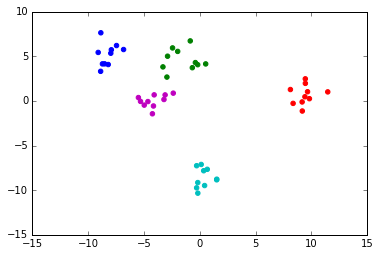

In [2]:
n_samples = 50 # Number of data points in our dataset
X, y = make_blobs(n_samples=n_samples, n_features=2, centers=5, shuffle=True, random_state=7)
#X: coordinates of the points
#y: cluster_id of each point

reference_colors = 'bgrcmyk' #support up to 7 clusters with different colors
colors_scatter = [reference_colors[j] for j in y ] #Given the cluster_id of each point, make a list with the appropriate colors

plt.scatter(X[:, 0], X[:,1], color = colors_scatter) #Generate the scatterplot

In [5]:
import numpy as np

def cluster_centroids(data, clusters, k=None):
    """Return centroids of clusters in data.

    data is an array of observations with shape (A, B, ...).

    clusters is an array of integers of shape (A,) giving the index
    (from 0 to k-1) of the cluster to which each observation belongs.
    The clusters must all be non-empty.

    k is the number of clusters. If omitted, it is deduced from the
    values in the clusters array.

    The result is an array of shape (k, B, ...) containing the
    centroid of each cluster.

    >>> data = np.array([[12, 10, 87],
    ...                  [ 2, 12, 33],
    ...                  [68, 31, 32],
    ...                  [88, 13, 66],
    ...                  [79, 40, 89],
    ...                  [ 1, 77, 12]])
    >>> cluster_centroids(data, np.array([1, 1, 2, 2, 0, 1]))
    array([[ 79.,  40.,  89.],
           [  5.,  33.,  44.],
           [ 78.,  22.,  49.]])

    """
    if k is None:
        k = np.max(clusters) + 1
    result = np.empty(shape=(k,) + data.shape[1:])
    
    for i in range(k):
        np.mean(data[clusters == i], axis=0, out=result[i])
    return result

import scipy.spatial

def kmeans(data, k=None, centroids=None, steps=20):
    """Divide the observations in data into clusters using the k-means
    algorithm, and return an array of integers assigning each data
    point to one of the clusters.

    centroids, if supplied, must be an array giving the initial
    position of the centroids of each cluster.

    If centroids is omitted, the number k gives the number of clusters
    and the initial positions of the centroids are selected randomly
    from the data.

    The k-means algorithm adjusts the centroids iteratively for the
    given number of steps, or until no further progress can be made.

    >>> data = np.array([[12, 10, 87],
    ...                  [ 2, 12, 33],
    ...                  [68, 31, 32],
    ...                  [88, 13, 66],
    ...                  [79, 40, 89],
    ...                  [ 1, 77, 12]])
    >>> np.random.seed(73)
    >>> kmeans(data, k=3)
    array([1, 1, 2, 2, 0, 1])

    """
    if centroids is not None and k is not None:
        assert(k == len(centroids))
    elif centroids is not None:
        k = len(centroids)
    elif k is not None:
        # Forgy initialization method: choose k data points randomly.
        centroids = data[np.random.choice(np.arange(len(data)), k, False)]
    else:
        raise RuntimeError("Need a value for k or centroids.")

    for iteration in range(max(steps, 1)):
        # Squared distances between each point and each centroid.
        sqdists = scipy.spatial.distance.cdist(centroids, data, 'sqeuclidean')

        # Index of the closest centroid to each data point.
        clusters = np.argmin(sqdists, axis=0)

        new_centroids = cluster_centroids(data, clusters, k)
        if np.array_equal(new_centroids, centroids):
            print("Converged at %d iterations."%iteration)
            break

        centroids = new_centroids

    return clusters

Converged at 2 iterations.


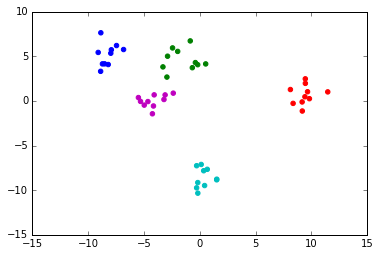

In [6]:
y_pred = kmeans(X, 5, steps = 100)
colors_scatter = [reference_colors[j] for j in y ]
plt.scatter(X[:, 0], X[:,1], color = colors_scatter)